In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'MOBYSOUND_WHALES'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [104]:
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=10000,
    mel_upper_edge_hertz=46000.0,
    butter_lowcut = 3000,
    butter_highcut = 46000,
    ref_level_db = 20,
    min_level_db = -25,
    win_length_ms = 0.1,
    hop_length_ms = .05,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [105]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [106]:
# dataset.data_files = {i:dataset.data_files[i] for i in list(dataset.data_files.keys())[:5]}

In [146]:
[(i.data["common_name"], i.data['samplerate_hz']) for i in list(dataset.data_files.values())]

[('Pilot whale', 96000),
 ('Melon headed whale', 96000),
 ('Melon headed whale', 96000),
 ('Sperm whale', 96000),
 ('Pilot whale', 96000),
 ('Pilot whale', 96000),
 ('Pilot whale', 96000),
 ('Sperm whale', 96000),
 ('Melon headed whale', 96000),
 ('Pilot whale', 96000),
 ('Pilot whale', 96000)]

In [108]:
dataset.sample_json

OrderedDict([('indvs',
              OrderedDict([('UNK',
                            OrderedDict([('clicks',
                                          OrderedDict([('start_times',
                                                        [2.613,
                                                         2.8169999999999997,
                                                         47.935,
                                                         48.146,
                                                         48.355,
                                                         48.56100000000001,
                                                         98.845,
                                                         99.49799999999999,
                                                         100.105,
                                                         101.176,
                                                         101.874,
                                                         111.943,
  

In [32]:
len(dataset.data_files)

11

#### Create dataset based upon JSON

In [33]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [34]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="clicks",
            dict_features_to_retain = ['common_name'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    4.4s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    4.4s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    4.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    4.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    4.5s finished


73991

In [35]:
len(syllable_df)

73991

In [36]:
syllable_df[:3]

,start_time,end_time,indv,indvi,common_name,key
0,2.613,2.622,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc
1,2.817,2.825,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc
2,47.935,47.942,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc


### get audio for dataset

In [37]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    7.3s remaining:   32.8s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    7.7s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    9.5s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:   11.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   12.9s finished


73991

In [38]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [39]:
syllable_df = syllable_df[np.array(df_mask)]

In [40]:
syllable_df[:3]

,start_time,end_time,indv,indvi,common_name,key,audio,rate
0,2.613,2.622,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[2.145874317831923e-05, 5.026228296654638e-05,...",96000
1,2.817,2.825,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[0.0003874310627197528, 0.00013647139070234294...",96000
2,47.935,47.942,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[-0.00030892247544219873, -0.00030081205851690...",96000


In [41]:
sylls = syllable_df.audio.values

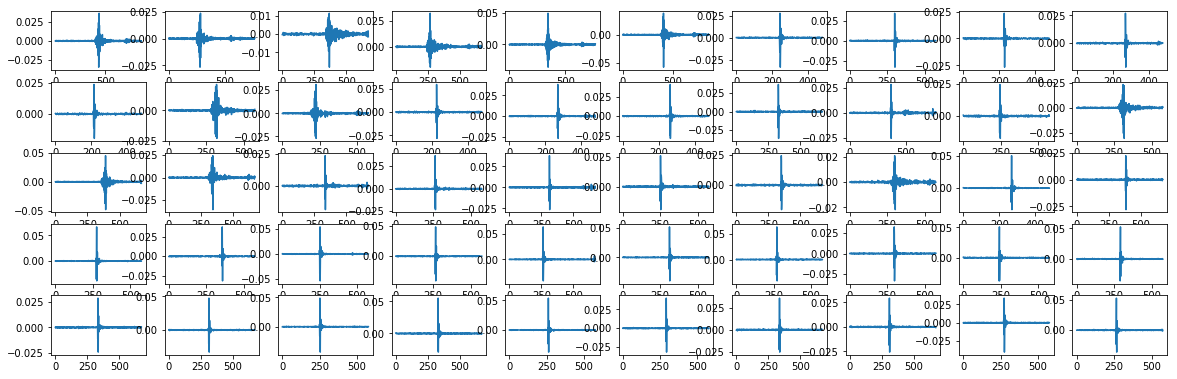

In [42]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [43]:
syllable_df['audio'] = [i/np.max(i) for i in syllable_df.audio.values]

### Create spectrograms

In [154]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [155]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [156]:
max_pts = [np.argmax(np.abs(i)) for i in syllable_df.audio.values]

(array([4.0080e+04, 2.4704e+04, 1.7050e+03, 3.1400e+02, 1.9800e+02,
        3.3900e+02, 9.3000e+01, 7.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([ 100. ,  219.5,  339. ,  458.5,  578. ,  697.5,  817. ,  936.5,
        1056. , 1175.5, 1295. ]),
 <a list of 10 Patch objects>)

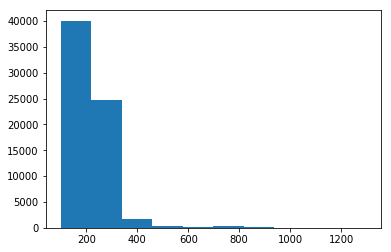

In [157]:
plt.hist(max_pts)

In [158]:
surrounding = 50 #int(100*(96000/200000))
syllables_wav = [wav[mx - surrounding: mx+surrounding] for wav, mx in zip(syllables_wav, max_pts)]

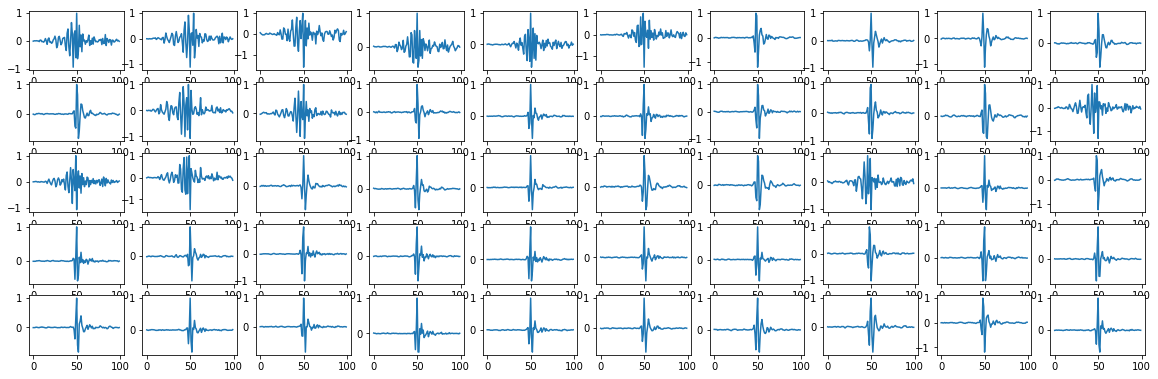

In [159]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(syllables_wav), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [160]:
good_syllables = np.array([len(i) >= 200 for i in syllables_wav])
good_syllables[:5]

array([False, False, False, False, False])

In [119]:
syllables_wav = np.array(syllables_wav)[good_syllables]

In [120]:
syllable_df = syllable_df[good_syllables]

In [121]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1946s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0948s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1279s.) Setting batch_

### Rescale spectrogram
- using log rescaling

In [122]:
log_scaling_factor = 10

In [123]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0088s.) Setting batch_size=44.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0088s.) Setting batch_size=2010.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4068 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1634s.) Setting batch_size=1005.
[Parallel(n_jobs=-1)]: Done 26178 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 67445 out of 67445 | elapsed:   11.1s finished


(25.0, 10) (640, 1600) 25.0 64 1600


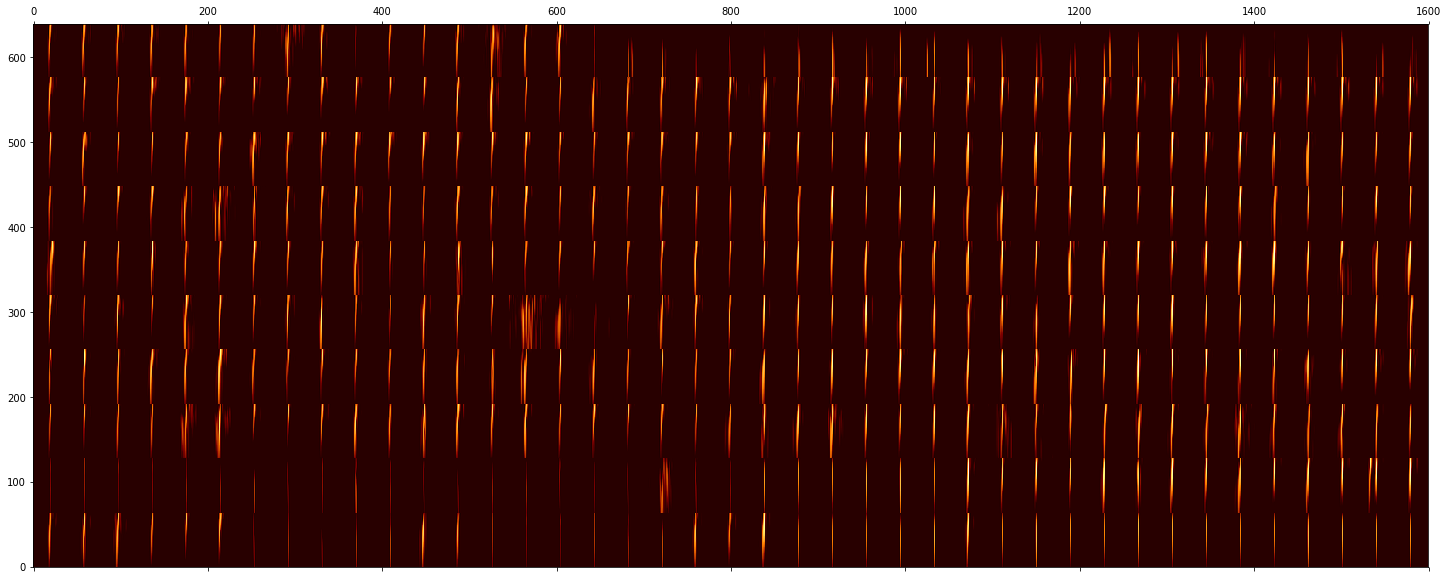

In [124]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [125]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [126]:
syllable_df[:3]

,start_time,end_time,indv,indvi,common_name,key,audio,rate,spectrogram
0,2.613,2.622,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[0.0005844428550265743, 0.00136892603229444, 0...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2.817,2.825,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[0.01635617727839399, 0.005761412737757453, -0...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,47.935,47.942,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[-0.02721198936915198, -0.026497568772740256, ...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [127]:
import seaborn as sns

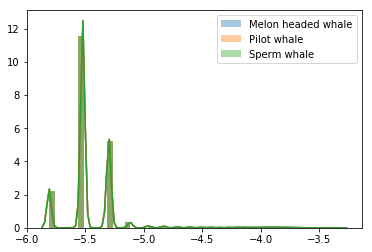

In [138]:
for indv in np.unique(syllable_df.common_name):
    sns.distplot(
        np.log(
            syllable_df[syllable_df.common_name == common_name]["end_time"].values
            - syllable_df[syllable_df.common_name == common_name]["start_time"].values
        ),
        label=indv,
    )
plt.legend()

In [129]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0252s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1159s.) Setting batch_size=48.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3408 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4416 tasks      | elapsed:    1.0s
[Parall

(25.0, 10) (640, 1600) 25.0 64 1600


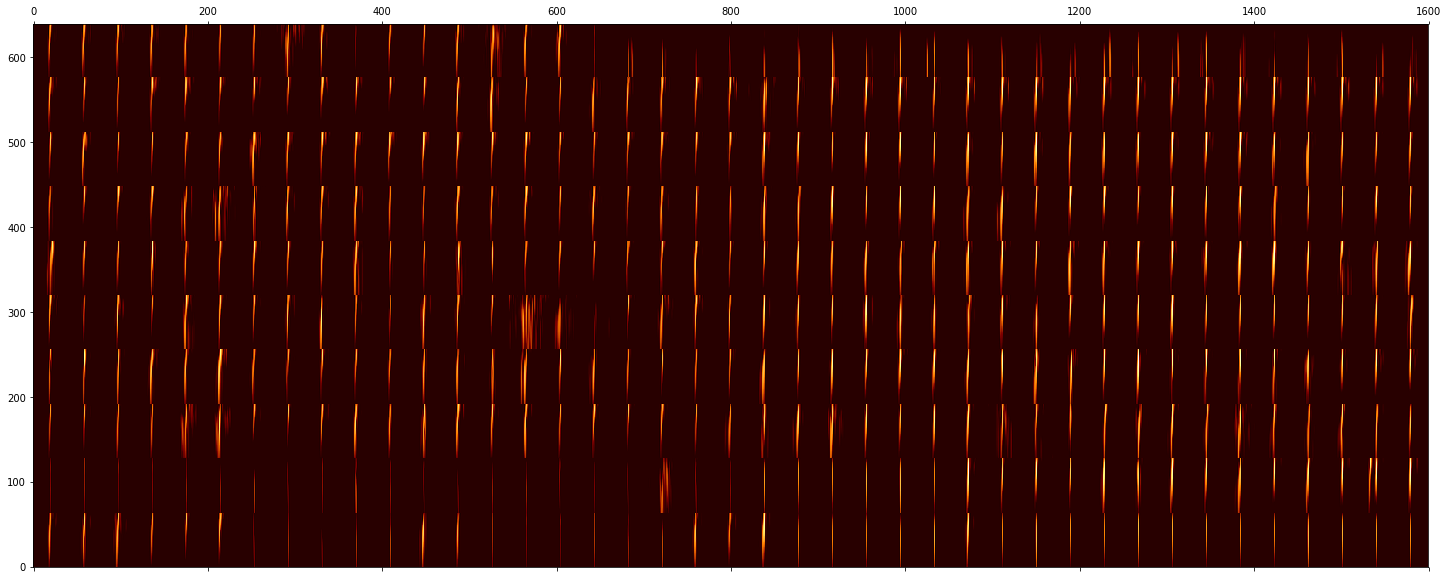

In [139]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [140]:
np.shape(syllables_spec)

(67445, 64, 39)

In [141]:
syllable_df['spectrogram'] = syllables_spec

In [142]:
syllable_df[:3]

,start_time,end_time,indv,indvi,common_name,key,audio,rate,spectrogram
0,2.613,2.622,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[0.0005844428550265743, 0.00136892603229444, 0...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2.817,2.825,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[0.01635617727839399, 0.005761412737757453, -0...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,47.935,47.942,UNK,0,Pilot whale,Set7-A1-093005-H01-0030-0100-0846-0916loc,"[-0.02721198936915198, -0.026497568772740256, ...",96000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### view syllables per indv

In [143]:
syllable_df.indv.unique()

array(['UNK'], dtype=object)

Melon headed whale 5
(50.0, 2) (64, 1600) 25.0 64 1600


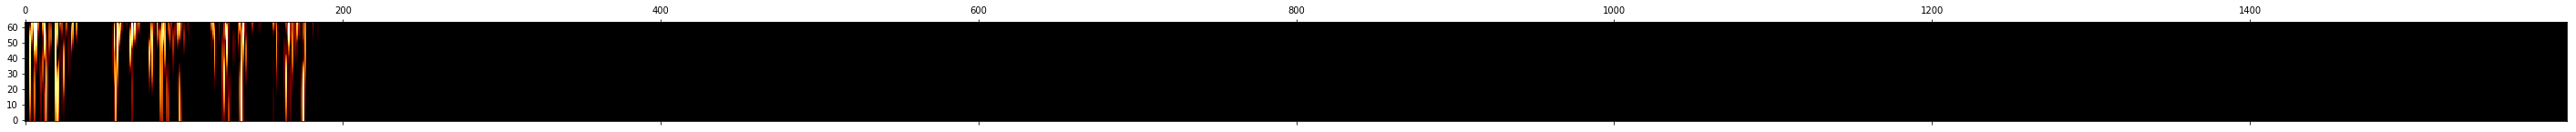

Pilot whale 10312


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(50.0, 32) (1024, 1600) 25.0 64 1600


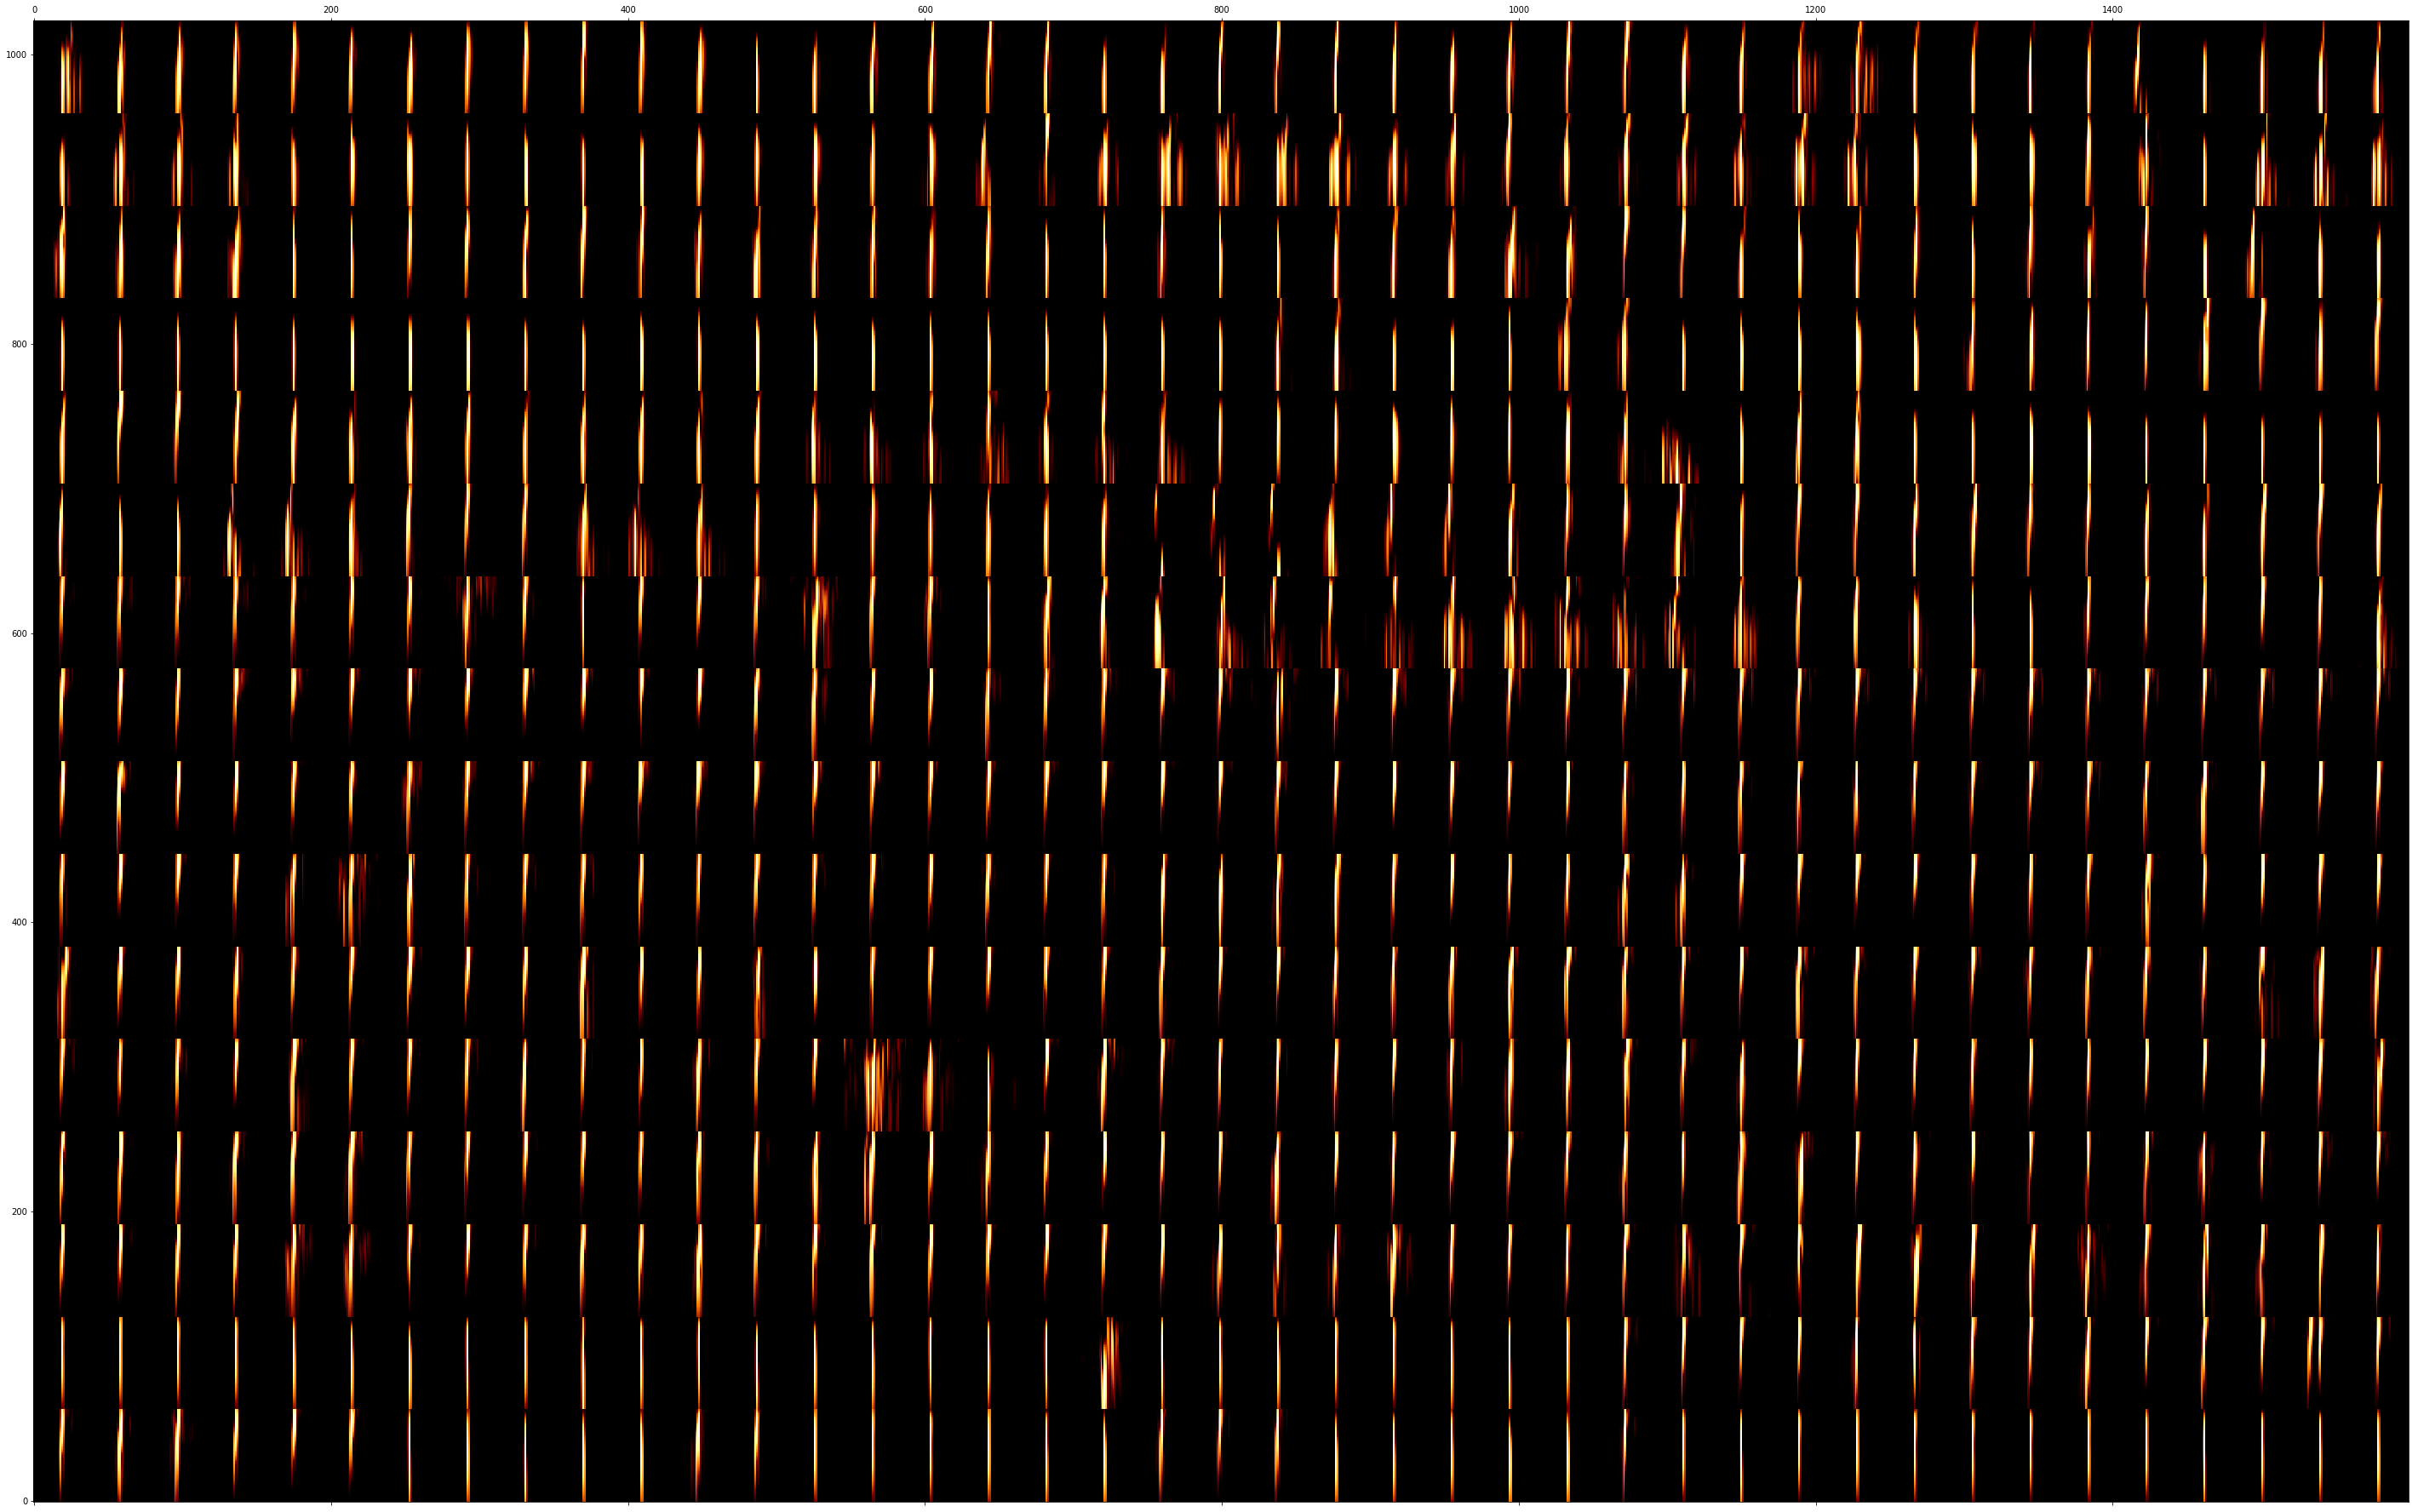

Sperm whale 57128
(50.0, 32) (1024, 1600) 25.0 64 1600


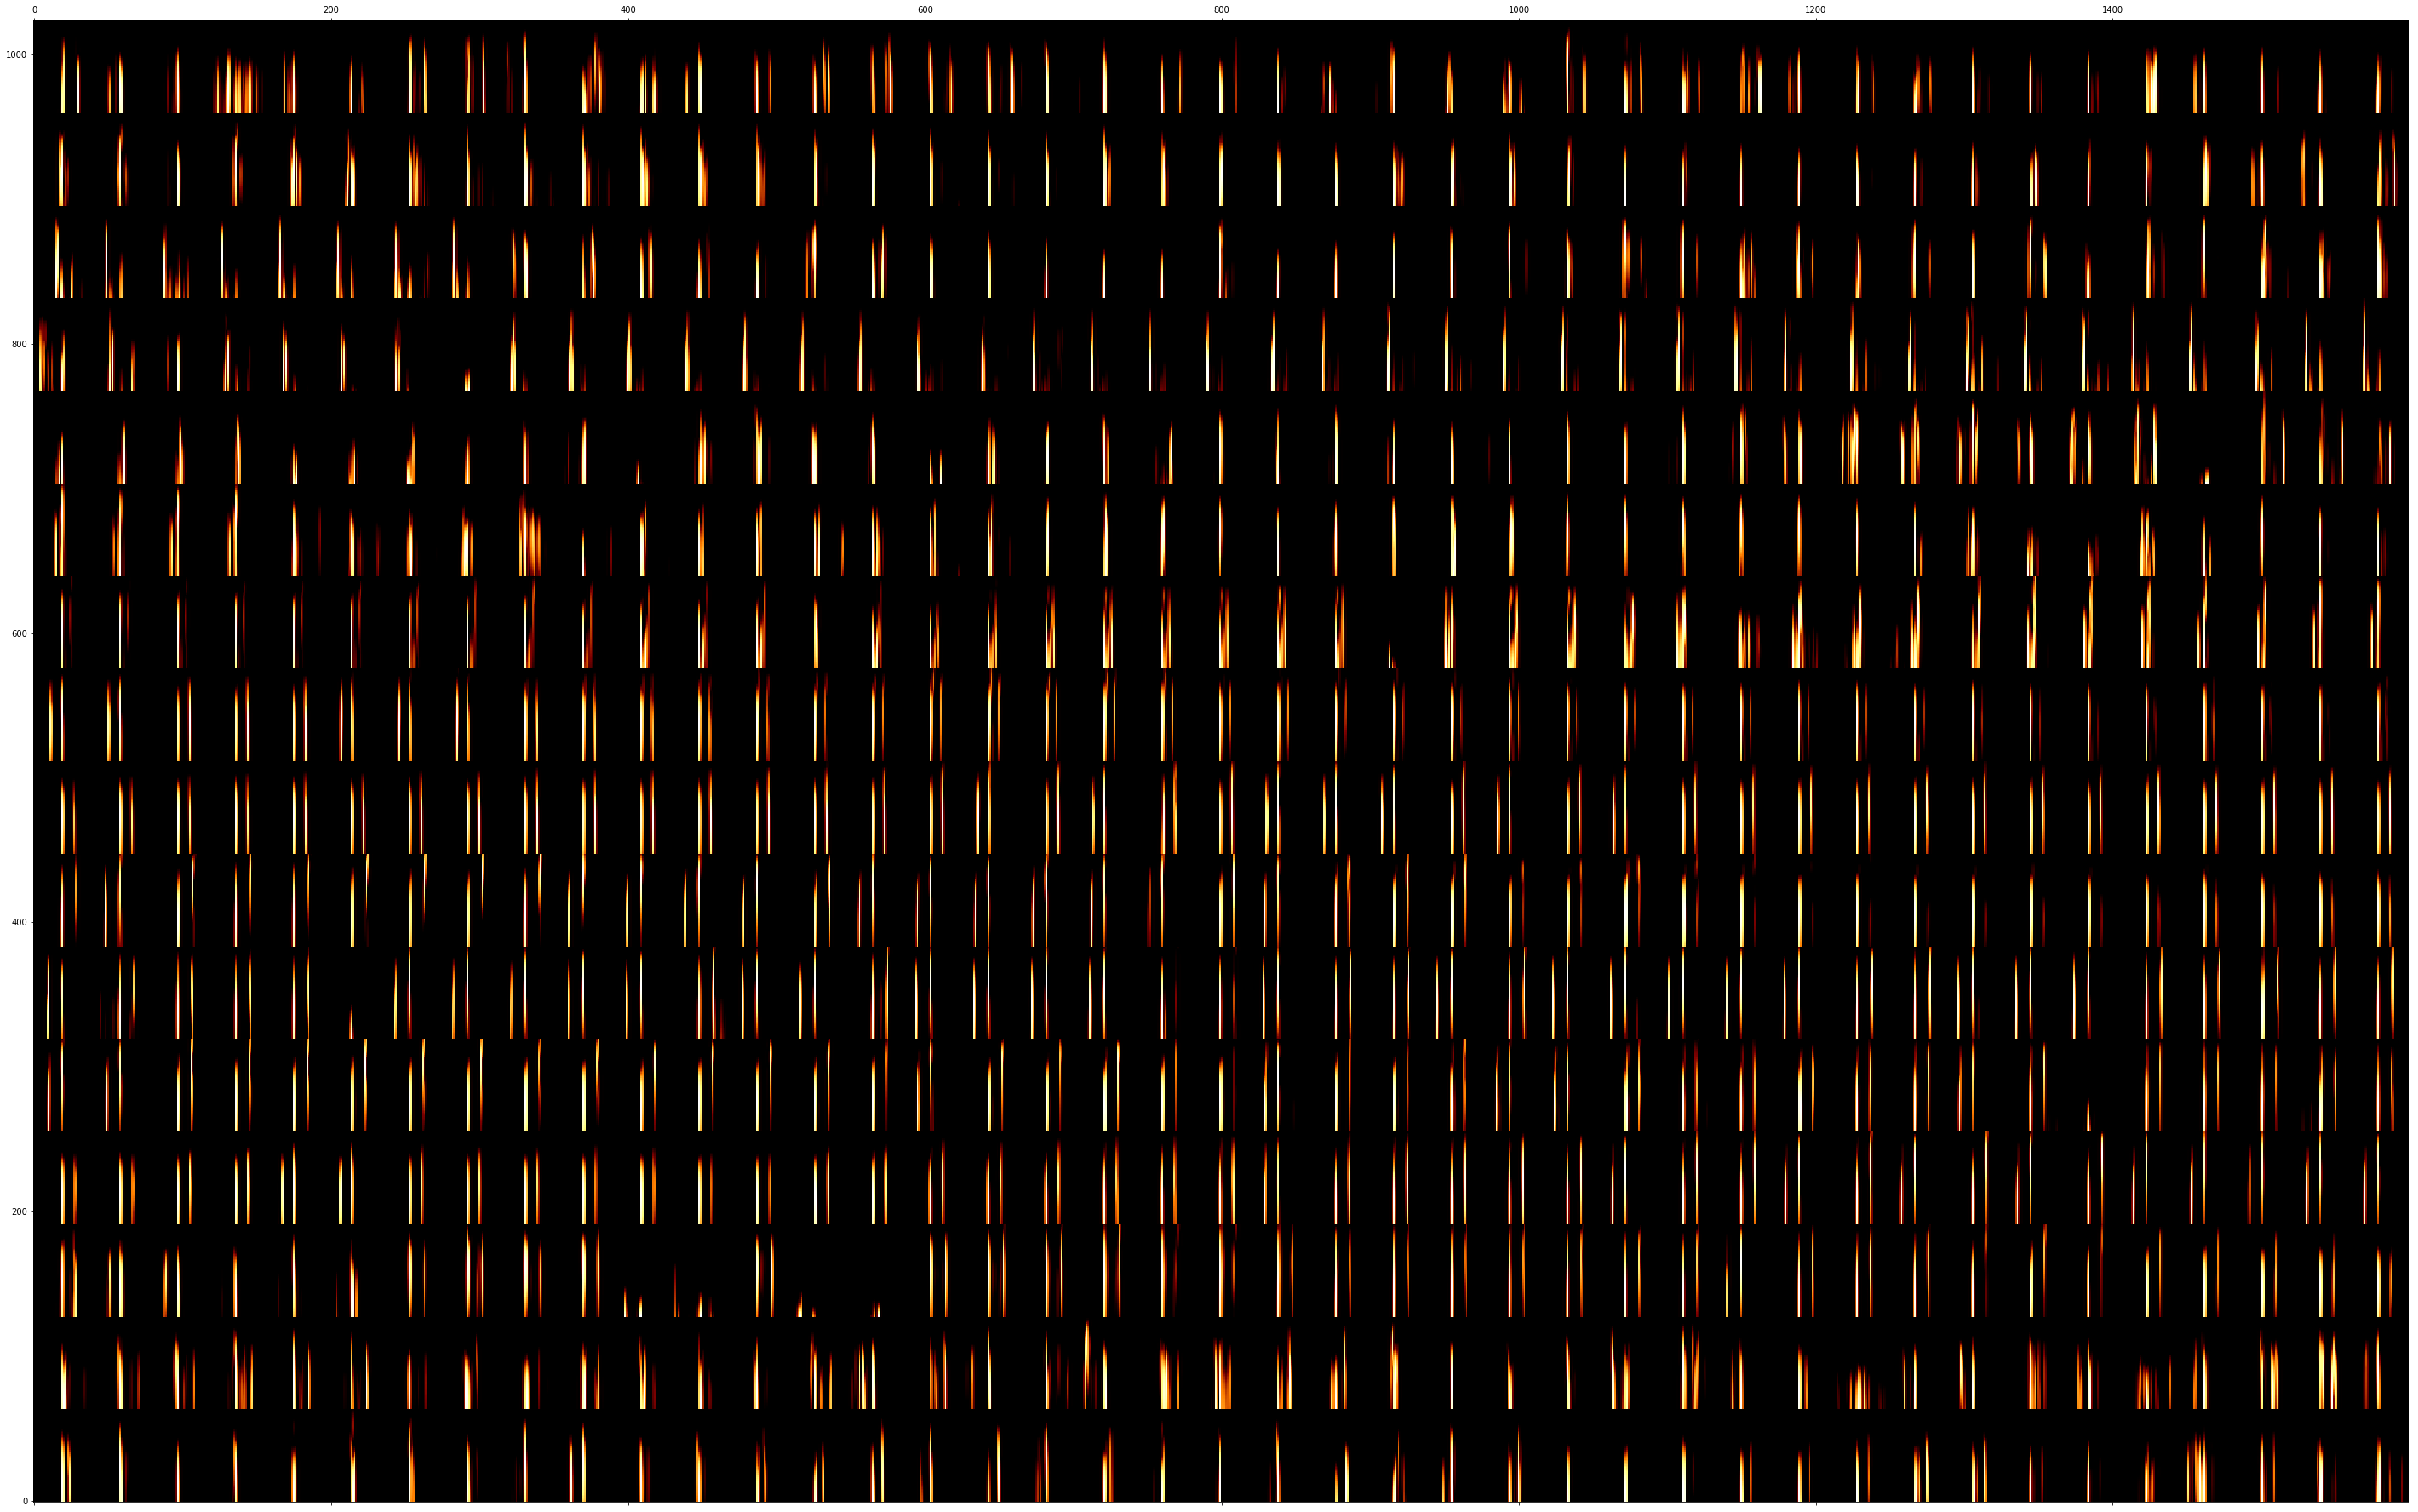

In [145]:
for common_name in np.sort(syllable_df.common_name.unique()):
    print(common_name, np.sum(syllable_df.common_name == common_name))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.common_name == common_name].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [61]:
save_loc = DATA_DIR / 'syllable_dfs' / 'mobysound_whales' / 'whale_clicks.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)